In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

# Get the current research's directory
research_dir = os.path.dirname(os.path.abspath('__file__'))

# Move one directory back
parent_dir = os.path.dirname(research_dir)

# Change the current working directory to the parent directory
os.chdir(parent_dir)

# Print the current working directory to confirm
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/eiingeeel/projects/frankenst-ai


In [4]:
from services.llm import LLMServices

# Inicializa lo necesario (leer YAML, configurar modelos, etc.)
LLMServices.launch()

# Accede directamente al modelo configurado
model = LLMServices.model
embeddings = LLMServices.embeddings


In [ ]:
# Define Vector DB
from langchain_chroma import Chroma

vectorstore = Chroma(
    collection_name="pokemon_series",
    embedding_function=embeddings,
    persist_directory="./.chroma_db",  # Where to save data locally, remove if not necessary
)

from frank.utils.rag.unstructured import MultiVectorDocumentIndexing

indexing = MultiVectorDocumentIndexing(llm=model, llm_multimodal=model, vectorstore=vectorstore)
# LOAD
file = indexing.load_pdf('artifacts/rag_docs/EP003 - Ash Catches a Pokémon.pdf')

# SPLIT
texts, tables, images_b64 = indexing.split_pdf(file_path=file)

# EMBBED & STORE
text_summaries, table_summaries, image_summaries = indexing.summarize_elements(texts=texts, tables=tables, images=images_b64)

chunks_dicts = {
    "texts": (texts, text_summaries),
    "tables": (tables, table_summaries),
    "images": (images_b64, image_summaries),
}

retriever = indexing.embed_store_documents(
    chunks_dicts=chunks_dicts,)

Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [25]:
docs = retriever.invoke("In the chapter 3 of pokemon series, who is the pokemon who was staring at the moon?")

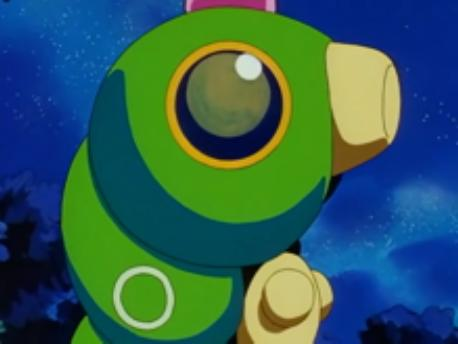

In [42]:
from frank.utils.rag.processing import parse_docs, show_base64_image

docs_dict = parse_docs(docs)
show_base64_image(docs_dict['images'][0])

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from base64 import b64decode



def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | model
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | model
        | StrOutputParser()
    )
)

In [27]:
response = chain.invoke(
    "In the chapter 3 of pokemon series, who is the pokemon who was staring at the moon?"
)

print(response)

Based on the provided context and the first image, the Pokémon staring at the moon in chapter 3 of the Pokémon series ("Ash Catches a Pokémon") is **Caterpie**. The context also mentions that "Caterpie shares with Pikachu its dream of evolving into a Butterfree" at night, which further supports that Caterpie is the one gazing at the moon.
